# Postmating response in axenic and control _D. melanogaster_ females

Load Packages:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

'%!in%' <- function(x,y)!('%in%'(x,y))
    
# The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))

Load read count data:

In [2]:
counts_bt2.fbgn = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_hs2.mstg = read.table("Hisat2/gene_counts.csv", header=T, row.names=1, com='', check.names=F)

Load annotation files:

In [7]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Generate sample info object:

In [8]:
sampleData = read.table("eXpress/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

Output library size object:

In [9]:
bt2LibSizes <- as.data.frame(colSums(counts_bt2.fbgn))
libSizes <- cbind(sample = row.names(bt2LibSizes), bt2LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "counts")
libSizes = merge(libSizes, sampleInfo, by.x = "sample", by.y = "Replicate")

Make a barplot of library sizes:

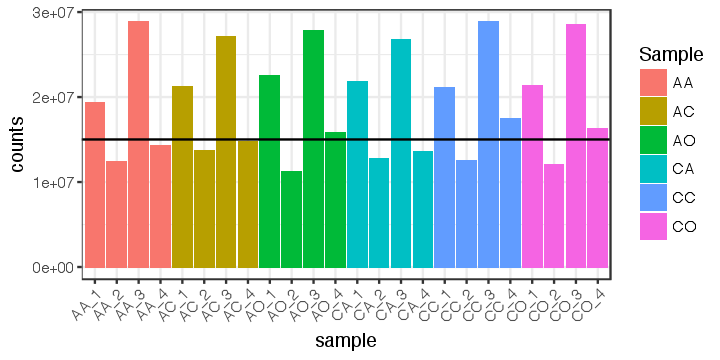

In [10]:
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(sample, counts, fill = Sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 15000000) 
# dev.off()

In [12]:
cpm_bt2.fbgn <- cpm(counts_bt2.fbgn)
thresh_bt2.fbgn <- cpm_bt2.fbgn > 5
keep_bt2.fbgn <- rowSums(thresh_bt2.fbgn) >= 2
countsKeep_bt2.fbgn <- counts_bt2.fbgn[keep_bt2.fbgn,]
# countsKeep_bt2.fbgn <- subset(countsKeep_bt2.fbgn, rownames(countsKeep_bt2.fbgn) %!in% wierd_genes)
dim(countsKeep_bt2.fbgn)

[1] 5551   24

In [14]:
groups = factor(sampleInfo$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

In [15]:
dgeList <- DGEList(counts = countsKeep_bt2.fbgn, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03956 0.06008 0.07531 0.13050 0.11400 3.49700 

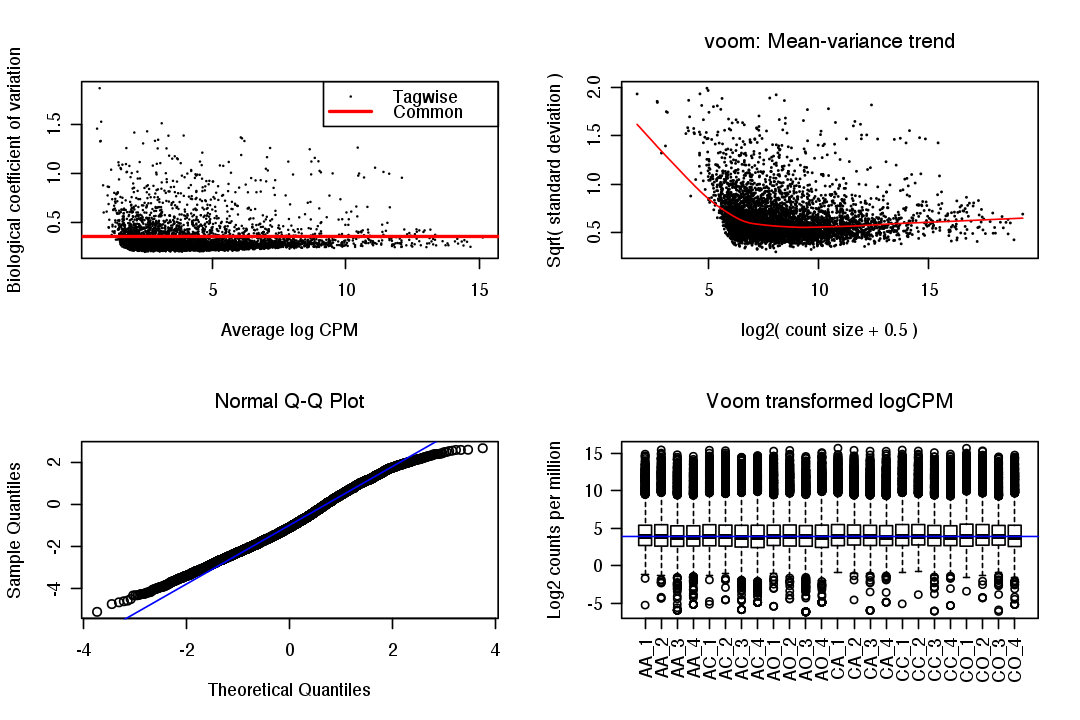

In [16]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
virgin.voom = voom(dgeList, design, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

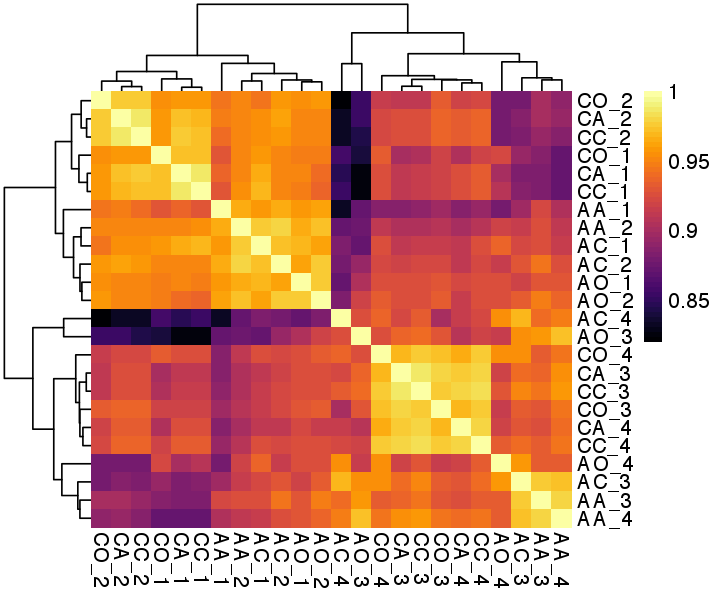

In [18]:
## Plot sample correlation
data = log2(countsKeep_bt2.fbgn+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 6, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)

In [19]:
mdsObj <- plotMDS(dgeList, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo, by.x = "replicate", by.y = "Replicate")
mdsObj$replicate_num = gsub(".*_", "", mdsObj$replicate)

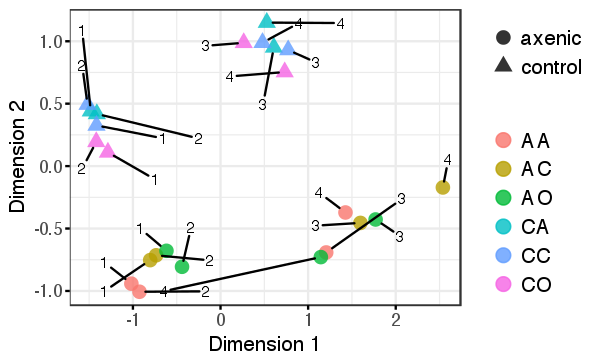

In [20]:
options(repr.plot.width = 5, repr.plot.height = 3)

# pdf("MDS.plot.pdf", width = 5, height = 3)
ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Sample",
              shape = "Female",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
                geom_text_repel(aes(label=replicate_num), 
                    force = 50, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
#                 scale_colour_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
#                 scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                labs ( x = "Dimension 1", y = "Dimension 2")
# dev.off()

In [27]:
head(annotation)

gene_symbol,organism_abbreviation,primary_FBgn,secondary_FBgn(s),annotation_ID,secondary_annotation_ID(s)
d,Dmel,FBgn0262029,"FBgn0032045,FBgn0086896,FBgn0000410,FBgn0025975,FBgn0032046,FBgn0051610,FBgn0069196",CG42840,"CG10595,CG13087,CG31610"
CG32532,Dmel,FBgn0052532,"FBgn0031027,FBgn0031028,FBgn0031029",CG32532,"CG14203,CG14202,CG14201"
CG3156,Dmel,FBgn0023536,,CG3156,
mRpL30,Dmel,FBgn0029718,,CG7038,
CG1631,Dmel,FBgn0031101,,CG1631,
CG12609,Dmel,FBgn0030952,,CG12609,


In [28]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

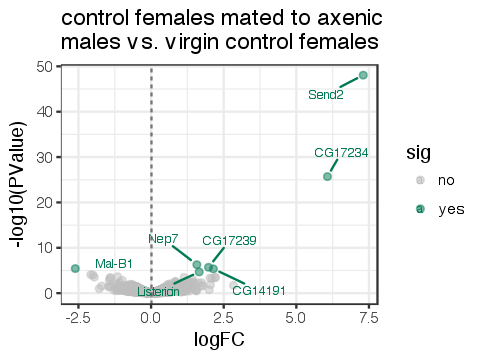

In [73]:
within_controls <- makeContrasts(CA.vs.CO=CA-CO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(CA.vs.CO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to axenic\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

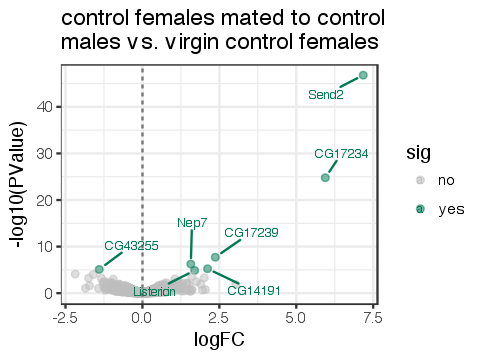

In [74]:
within_controls <- makeContrasts(CC.vs.CO=CC-CO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(CC.vs.CO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

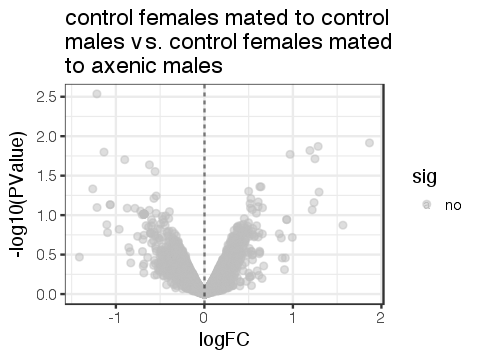

In [75]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(CC.vs.CA.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw())

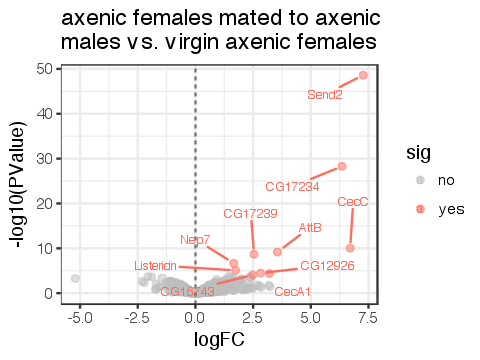

In [76]:
within_controls <- makeContrasts(AA.vs.AO=AA-AO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(AA.vs.AO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "axenic females mated to axenic\nmales vs. virgin axenic females", size = 2) +
    scale_colour_manual(values = c("gray","#ff6c5d")) +
    theme_bw())

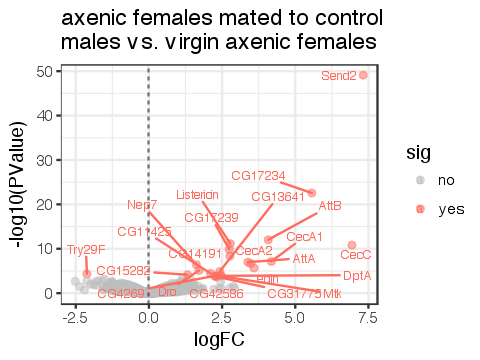

In [82]:
within_controls <- makeContrasts(AC.vs.AO=AC-AO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(AC.vs.AO.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "axenic females mated to control\nmales vs. virgin axenic females", size = 2) +
    scale_colour_manual(values = c("gray","#ff6c5d")) +
    theme_bw())

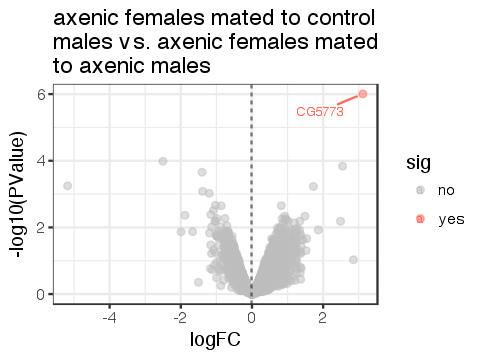

In [78]:
within_controls <- makeContrasts(AA.vs.AC=AA-AC,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
(AA.vs.AC.gg = ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "axenic females mated to control\nmales vs. axenic females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#ff6c5d")) +
    theme_bw())

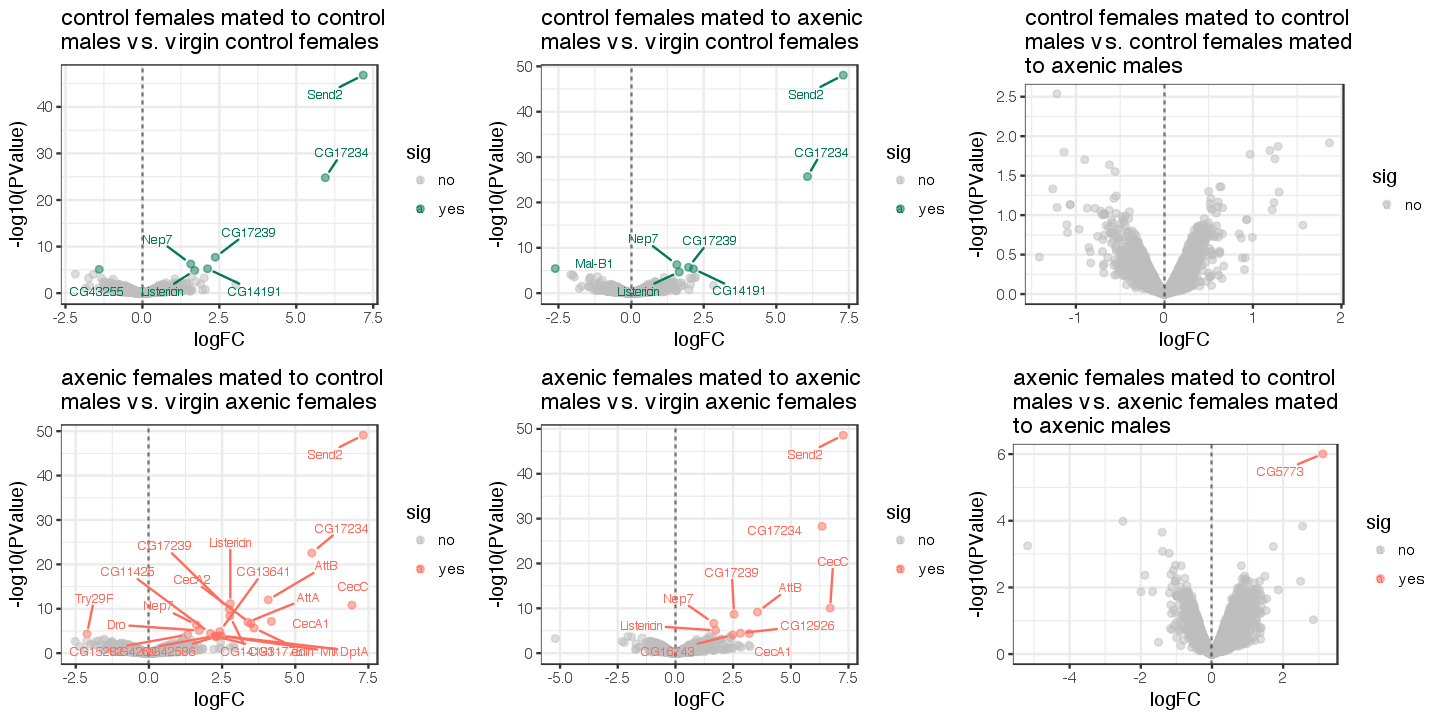

In [80]:
options(repr.plot.width = 12, repr.plot.height = 6)
# pdf("Figures/pairwiseDE.pdf", width = 12, height = 6)
plot_grid(CC.vs.CO.gg, CA.vs.CO.gg, CC.vs.CA.gg, AC.vs.AO.gg, AA.vs.AO.gg, AA.vs.AC.gg, ncol = 3)
# dev.off()

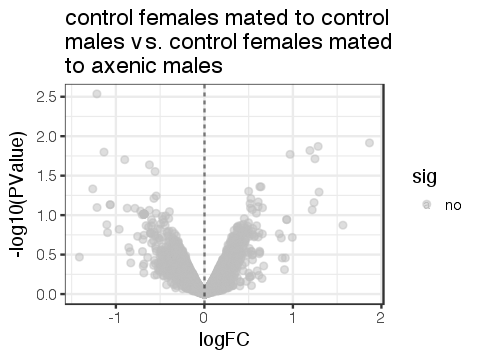

In [41]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#e93c00")) +
    theme_bw()

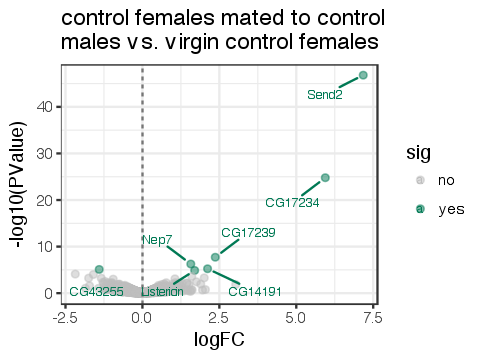

In [43]:
within_controls <- makeContrasts(CC.vs.CO=CC-CO,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. virgin control females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

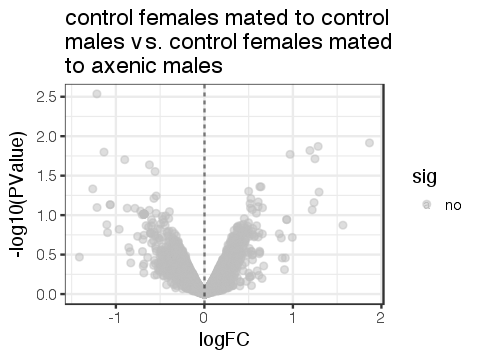

In [44]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

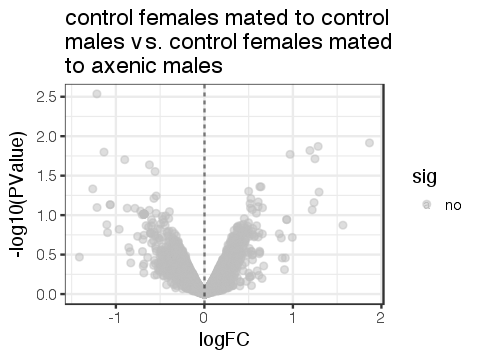

In [41]:
within_controls <- makeContrasts(CC.vs.CA=CC-CA,
                                 levels=design)

lrt.control <- glmLRT(dgeList_fit, contrast = within_controls)
lrt.control.tTags <- topTags(lrt.control, n = NULL)
lrt.control.table <- lrt.control.tTags$table
lrt.control.table$sig = ifelse(lrt.control.table$FDR < 0.05 & (lrt.control.table$logFC > 1 | lrt.control.table$logFC < -1), "yes", "no")
lrt.control.table$gene = rownames(lrt.control.table)
lrt.control.table = merge(lrt.control.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.control.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.control.table, sig == "yes"),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 2.5) +
    labs(title = "control females mated to control\nmales vs. control females mated\nto axenic males", size = 2) +
    scale_colour_manual(values = c("gray","#e93c00")) +
    theme_bw()

In [222]:
wierd_genes = subset(lrt.control.table, sig == "yes" & logFC > 1)$gene
length(wierd_genes)

[1] 472

In [226]:
mel_modENCODE = read.csv("~/Dropbox/Aedes-aegypti_files/Ethan/Analyses/proteomics/Other_species_proteomes/gene_rpkm_report_fb_2018_02_subset.tsv", header = T, sep = "\t")
mel_modENCODE_subset = subset(mel_modENCODE, select = c("FBgn_ID", "RNASource_name", "RPKM_value"))
mel_modENCODE_matrix = cast(mel_modENCODE_subset, FBgn_ID~RNASource_name, value = "RPKM_value")
mel_modENCODE_matrix2 <- mel_modENCODE_matrix[,-1]
rownames(mel_modENCODE_matrix2) <- mel_modENCODE_matrix[,1]

In [227]:
wierdMatrix = subset(mel_modENCODE_matrix2, rownames(mel_modENCODE_matrix2) %in% wierd_genes)

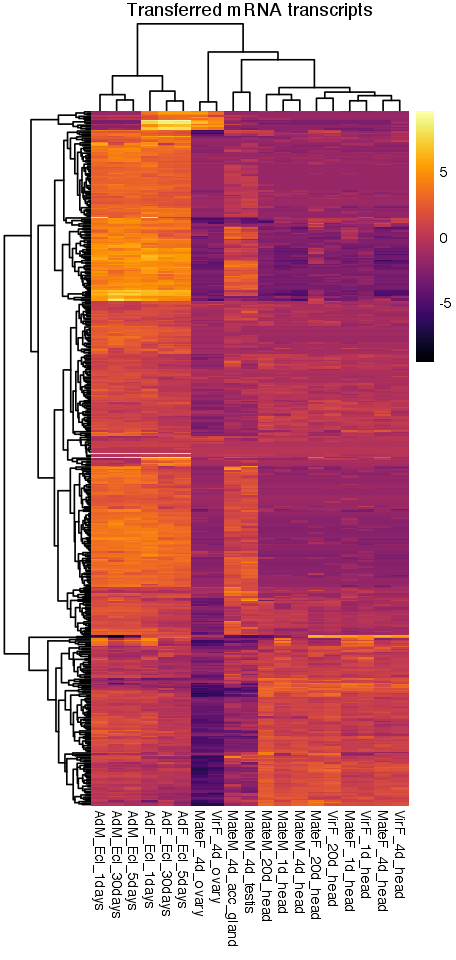

In [229]:
data = log2(wierdMatrix+1)
data = t(scale(t(data), scale=F))
# data[data < -3] = -3
# data[data > 3] = 3

options(repr.plot.width = 3.8, repr.plot.height = 8)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
#   annotation_row    = annotationType,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   cluster_col    = FALSE,
  annotation_names_row = F,
  main              = "Transferred mRNA transcripts",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 3.8, 
#   height            = 5,
  fontsize          = 8    
)